# Spatial stuff

### Load packages

In [7]:
import json
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# spatial stuff
import geopandas as gpd
import fiona
import folium
import shapely

Extra functions


In [8]:
def convert_to_danish_crs(df):
    df.to_crs(epsg=25832, inplace=True)


from scipy.spatial import Voronoi

# The function below is taken from https://gist.github.com/pv/8036995

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
        
    
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


# Making a wrapper function for geopandas

def voronoi_wrapper(points, origin_geom):
    '''
    Returns a series of Voronoi shapely objects contruced
    from the centroids.
    '''
    
    vor = Voronoi(points)
    
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    def _polygon_intersect(points):
        poly = shapely.geometry.Polygon(points)
        poly_intersect_origin = poly.intersection(origin_geom)
        return poly_intersect_origin
    
    poly_list = [_polygon_intersect(vertices[region]) for region in regions]
    
    return gpd.GeoSeries(poly_list, index=points.index)

### Administrative areas of Denmark

We start off by loading adminstrative shape files for parishes and municipalities


In [3]:
admin_dk_repo = 'https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/'


# parishes (church districts)
sogne = gpd.read_file(admin_dk_repo+'sogne.geojson')    

# municipalities
kommuner = gpd.read_file(admin_dk_repo+'kommuner.geojson')

# rename columns and change coordinate system
for gdf in sogne, kommuner:
    gdf.columns = gdf.columns.str.lower()
    gdf.to_crs(epsg=25832, inplace=True)

# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

kommuner = kommuner\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')

# select Copenhagen shapes
select_cph = kommuner.komnavn.isin(['København', 'Frederiksberg'])
kommuner_cph = kommuner[select_cph]

From the administrative areas we can make unified shapes

In [4]:
# DK as one shape
denmark_shape = kommuner.unary_union

# Capital region (without Bornholm) as one shape
cap_reg = kommuner.regionsnavn.isin(['Region Hovedstaden'])
non_bornholm = kommuner.bounds.minx<800000

kommuner_select = kommuner[cap_reg & non_bornholm]
cap_region = kommuner_select.unary_union

# Capital region (without Bornholm) as one shape
sealand_reg = kommuner.regionsnavn.isin(['Region Hovedstaden', 'Region Sjælland'])
non_bornholm = ~ kommuner.komnavn.isin(['Bornholm', 'Christiansø'])

kommuner_select_sealand = kommuner[sealand_reg & non_bornholm]
sealand_shape = kommuner_select_sealand.unary_union

# Plots and structured data 

### World countries as shapes in geodataframe

In [5]:
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_shapes = world_map.geometry

### Youth in Copenhagen  
Use the example DST api and merge with municipal shapes 


In [6]:
%run statistics_denmark_api.ipynb

Merge data with shapes

In [7]:
gdf_parish_young = sogne.merge(youth_stats[youth_stats.year==2010])
        
# select capital region 
gdf_parish_young_cap_reg = gdf_parish_young[gdf_parish_young.intersects(cap_region)]

### Plot youth count

C:\Users\bvq720\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


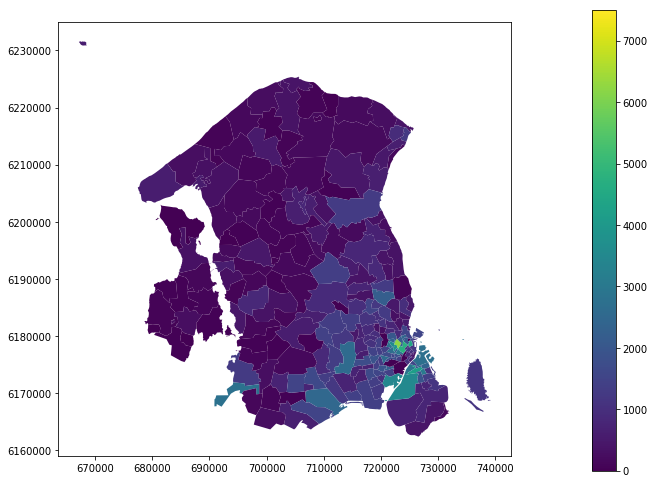

In [8]:
vmin, vmax = 0, 7500
ax = gdf_parish_young_cap_reg\
    .plot(column=c_count, 
          figsize=(11,8), 
          vmin=vmin, 
          vmax=vmax,
          cmap='viridis')

# add colorbar
f_cph_young_count = ax.get_figure()
cax = f_cph_young_count.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
f_cph_young_count.colorbar(sm, cax=cax)

### Plot youth share

C:\Users\bvq720\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


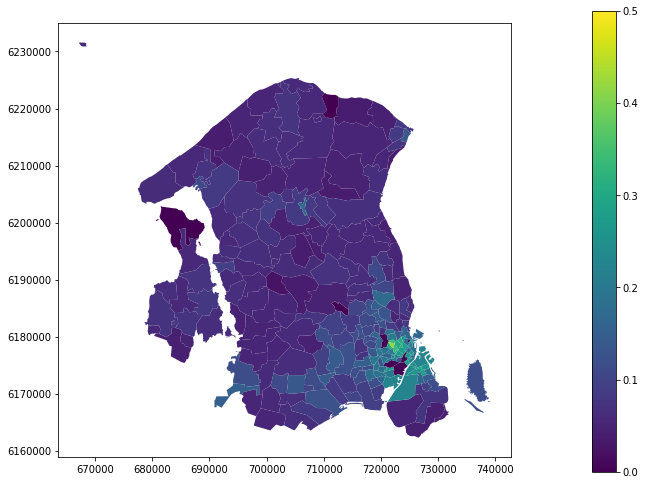

In [9]:
vmin, vmax = 0, .5
ax = gdf_parish_young_cap_reg\
        .plot(column=c_share, 
              figsize=(11,8), 
              vmin=vmin, 
              vmax=vmax,
              cmap='viridis')

# add colorbar
f_cph_young = ax.get_figure()
cax = f_cph_young.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
f_cph_young.colorbar(sm, cax=cax)

## Danish house prices from sales data

Note this data is made from Snorre's scraping code.

<p><FONT color=red>You need to have downloaded the data before starting this script. See the accompanying exercises for instructions.</FONT></p>


In [10]:
price_gdf = gpd.read_file('house_prices.geojson')

Select 2012 price sales data and make Voronoi

In [11]:
# some address coordinates have multiple sales
# we handle this by making a slight perturbation
price_gdf['n'] = price_gdf.geometry.y
price_gdf['e'] = price_gdf.geometry.x

price_gdf[['e', 'n']] += np.random.normal(scale=100, size=(len(price_gdf), 2))

# select 2012 sales and remove outliers
selection = (price_gdf.sale_year==2012) & \
            (price_gdf.price_area.between(1000,100000))

# make selection, reset_index and copy
prices_12 = price_gdf[selection].reset_index(drop=True).copy()



Voronoi prices

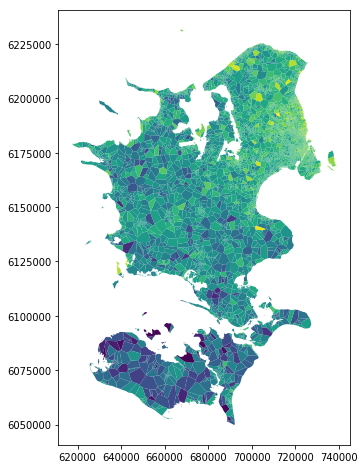

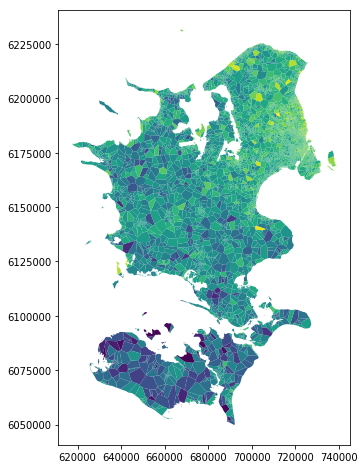

In [12]:
# make voronoi shapes
voronoi_geom = voronoi_wrapper(prices_12[['e', 'n']].copy(), 
                               sealand_shape)

# turn into new GeoDataFrame for plotting
prices_12_vor = gpd.GeoDataFrame(data=prices_12,
                                 geometry=voronoi_geom)

# make plots
f_price_pointcloud,ax = plt.subplots(figsize=(10,8))
prices_12.plot(column='price_area_log', markersize=4, ax=ax)

f_price_voronoi,ax = plt.subplots(figsize=(10,8))
prices_12_vor.plot(column='price_area_log', ax=ax)

# Open Street Maps (OSM)

In [11]:
from shapely.geometry import Point


overpass_base = "http://overpass-api.de/api/interpreter"

def query_overpass_gdf(tag, subtag='*', place='DK'):
    q = f"""
         [out:json];
         area["ISO3166-1"="{place}"][admin_level=2];
         (node["{tag}"="{subtag}"](area);
          way["{tag}"="{subtag}"](area);
          rel["{tag}"="{subtag}"](area);
         );
         out center;
         """
    
    response = requests.get(overpass_base, params={'data': q})    
    df = pd.DataFrame(response.json()['elements'])
    
    points = df[['lon','lat']].apply(Point, 1)
    gdf = gpd.GeoDataFrame(df,
                           geometry = points,
                           crs = {'init': 'epsg:4326'})

    gdf.to_crs(epsg=25832, inplace=True)
    
    return gdf

### Restaurant plots

In [ ]:
gdf_restaurant = query_overpass_gdf('amenity', 'restaurant')
f_restaurant_buffer, ax = plt.subplots(figsize=(14,8))
gs_rest_1km = gdf_restaurant.buffer(2500)
gs_rest_1km.plot(alpha=.3, ax=ax)

### Supermarket plots

In [16]:
gdf_supermarket = query_overpass_gdf('shop', 'supermarket')
gdf_supermarket['name'] = gdf_supermarket.tags.str['name'].fillna('')

In [17]:
from folium.plugins import MarkerCluster

m_dk_supermarket_cph = folium.Map(location=[55.7, 12.5],
                              tiles='Stamen Toner',
                              zoom_start=10)

marker_cluster_cph = MarkerCluster(
    overlay=True,
    control=False,
    icon_create_function=None)

In [18]:
from folium.plugins import MarkerCluster

m_dk_supermarket = folium.Map(location=[55.7, 12.5],
                              tiles='Stamen Toner',
                              zoom_start=10)

marker_cluster = MarkerCluster(
    overlay=True,
    control=False,
    icon_create_function=None)

geoms = gdf_supermarket.set_index('name').geometry.items()
for name, point in geoms:        
    marker = folium.Marker(location=[point.y, point.x])
    n = name.replace('ø','oe').replace('å','aa').replace('æ','ae').replace("'",'')
    
    popup = n
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)
    
marker_cluster.add_to(m_dk_supermarket)

# m_dk_supermarket  

AttributeError: 'DataFrame' object has no attribute 'geometry'